In [24]:
%pip install wandb

In [25]:
import pandas as pd
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib.lines import Line2D

In [26]:
from read_wandb import wandb_results
api = wandb_results("NLP2024_PROJECT_RavidDimant", wandb_username="technion-nlp")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

In [27]:
def result_metric(sweeps, group_name, drop_list=[], drop_HPT=False, metric=BASE_METRIC, epoch="best"):
    df = api.get_sweeps_results(sweeps, metric=metric)

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1 and col != "config_expert_reliability_path"]
    print(HPT_cols)
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]

    # Remove non-numeric columns before computing mean and std
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[list(numeric_cols) + [col for col in HPT_cols if col not in numeric_cols]]

    grouped = df_numeric.groupby([c for c in HPT_cols if c != "config_seed"])

    mean_df = grouped.mean()
    std_df = grouped.std()

    # Re-add non-numeric columns before computing best_col
    for col in config_cols:
        if col not in mean_df.columns:
            mean_df[col] = df[col]

    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)

    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)

    summary_df['CI_length'] = summary_df['CI'].apply(lambda x: x[1] - x[0])
    summary_df['Min_Max'] = summary_df['values'].apply(lambda x: (min(x), max(x)))

    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


### Part A - The bot plays with probability as en expert & the DM plays as in the original work setting

In [41]:
sweep_ids = ["4903tikt"]

directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)

df_sweeps_results = result_metric(sweep_ids, "bot_strategy_prob", drop_HPT=False, epoch="best")

Total number of sweeps: 1
Download sweep_id='4903tikt' data...
['config_seed', 'config_bot_strategy_prob']


<ipython-input-27-73f0339e8a9c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
<ipython-input-27-73f0339e8a9c>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
<ipython-input-27-73f0339e8a9c>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This

In [42]:
df_sweeps_results

,mean,std,values,epoch,CI,CI_length,Min_Max
bot_strategy_prob,,,,,,,
0.00,0.835384,0.001674,"[0.8356763374371285, 0.8371188833125722, 0.835...",13,"(0.8338656761797086, 0.8365418649623948)",0.002676,"(0.8326009267319737, 0.8371188833125722)"
0.25,0.836145,0.001054,"[0.8358330045472527, 0.8375424390700242, 0.836...",19,"(0.8353376763775202, 0.8369862074708687)",0.001649,"(0.835043742059523, 0.8375424390700242)"
0.50,0.835832,0.003635,"[0.8385067866985255, 0.8392987434395344, 0.836...",14,"(0.8329772979877266, 0.8383402992530512)",0.005363,"(0.8303898036268176, 0.8392987434395344)"
0.75,0.835060,0.002550,"[0.8392114529490855, 0.8333754262878881, 0.835...",17,"(0.8332510544184635, 0.8372028260700066)",0.003952,"(0.8326258558861818, 0.8392114529490855)"
0.90,0.834872,0.003376,"[0.8329038178478622, 0.8358868497334315, 0.836...",18,"(0.8324039403672762, 0.8374823541163577)",0.005078,"(0.8301626082036124, 0.838813720739364)"
1.00,0.833692,0.002196,"[0.8357862538058541, 0.8335009661774766, 0.830...",9,"(0.8320345566658341, 0.8353489979167575)",0.003314,"(0.8306498793799676, 0.8358357578973014)"


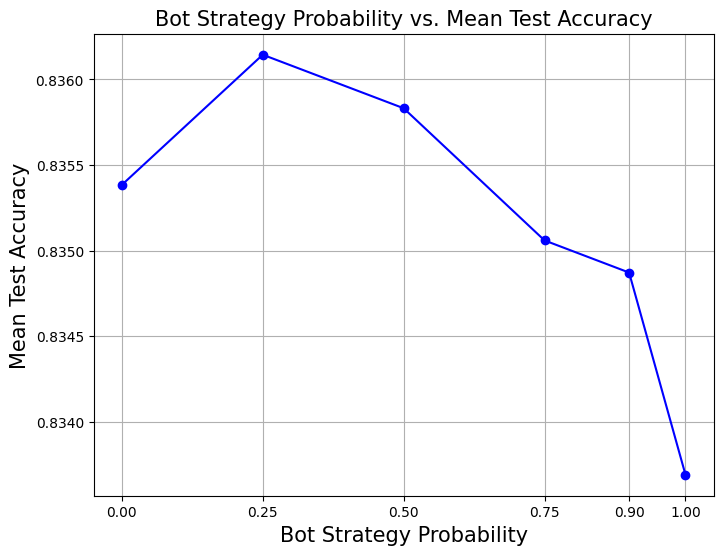

In [43]:
df_reset_index = df_sweeps_results.reset_index()
df = df_reset_index[['bot_strategy_prob', 'mean']]

plt.figure(figsize=(8, 6))
plt.plot(df['bot_strategy_prob'], df['mean'], marker='o', linestyle='-', color='b')

plt.xlabel('Bot Strategy Probability', fontsize=15)
plt.xticks([0, 0.25, 0.5, 0.75, 0.9, 1])
plt.ylabel('Mean Test Accuracy', fontsize=15)
plt.title('Bot Strategy Probability vs. Mean Test Accuracy', fontsize=15)


plt.grid(True)
plt.show()


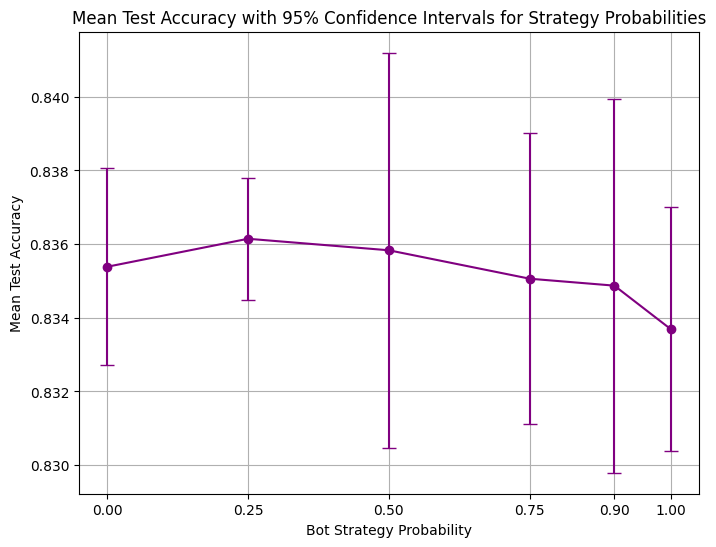

In [49]:
plt.figure(figsize=(8, 6))
plt.errorbar(df_sweeps_results.index, df_sweeps_results['mean'],
             yerr=df_sweeps_results['CI_length'], fmt='o', linestyle='-', capsize=5, color='purple')

plt.xlabel('Bot Strategy Probability')
plt.xticks([0, 0.25, 0.5, 0.75, 0.9, 1])
plt.ylabel('Mean Test Accuracy')
plt.title('Mean Test Accuracy with 95% Confidence Intervals for Strategy Probabilities')
plt.grid(True)
plt.show()


Total number of sweeps: 1
Download sweep_id='4903tikt' data...


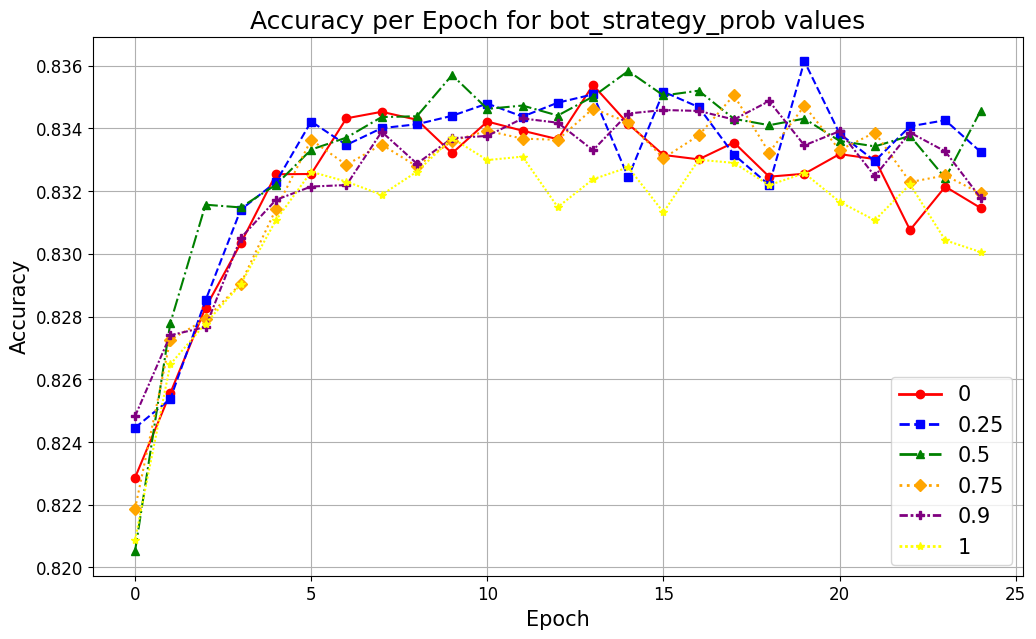

In [32]:
# Let us explore the accuracy per prob. along the epochs

df = api.get_sweeps_results(sweep_ids, metric=BASE_METRIC)

df = df[df['config_features'] == 'EFs']
df = df[df['config_online_simulation_factor'] == 4]

config_cols = [c for c in df.columns if "config_" in c and c != "config_wandb_run_id" and c != "config_online_simulation_size"]
param_cols = [col for col in config_cols if df[col].nunique() > 1 and col != "config_expert_reliability_path" and col != "config_seed"]
epoch_columns = [col for col in df.columns if "ENV_Test_accuracy_per_mean_user_and_bot_epoch" in col]

melted_df = df.melt(id_vars=param_cols + ["config_seed"], value_vars=epoch_columns, var_name='epoch', value_name='accuracy')
melted_df['epoch'] = melted_df['epoch'].str.extract('(\d+)').astype(int)
df_agg = melted_df.groupby(param_cols + ['epoch']).accuracy.agg(['mean', 'std']).reset_index()
df_agg = df_agg[df_agg['config_bot_strategy_prob'].isin([0, 0.25, 0.5 ,0.75, 0.9, 1])]

colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 1))]
markers = ['o', 's', '^', 'D', 'P', '*']
labels = [0, 0.25, 0.5 ,0.75, 0.9, 1]

# Plot each hyperparameter combination
unique_combinations = df_agg[param_cols].drop_duplicates()
plt.figure(figsize=(12, 7))

color_map = {idx: colors[i % len(colors)] for i, idx in enumerate(unique_combinations.index)}
linestyle_map = {idx: linestyles[i % len(linestyles)] for i, idx in enumerate(unique_combinations.index)}
marker_map = {idx: markers[i % len(markers)] for i, idx in enumerate(unique_combinations.index)}

for idx, combination in unique_combinations.iterrows():
    combination_mask = np.all([df_agg[col] == combination[col] for col in param_cols], axis=0)
    group = df_agg[combination_mask]
    plt.plot(group['epoch'], group['mean'], color=color_map[idx], linestyle=linestyle_map[idx], marker=marker_map[idx], label=f"Combination {idx}")

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy per Epoch for bot_strategy_prob values',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Create legend handles
handles = [Line2D([0], [0], color=color_map[idx], linestyle=linestyle_map[idx], marker=marker_map[idx], lw=2) for idx in unique_combinations.index]
plt.legend(handles=handles, labels=labels, loc='lower right', fontsize=15)

plt.grid(True)
plt.show()


<ipython-input-33-11968af85dbd>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_exploded, x='bot_strategy_prob', y='values', palette='Set2')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple t

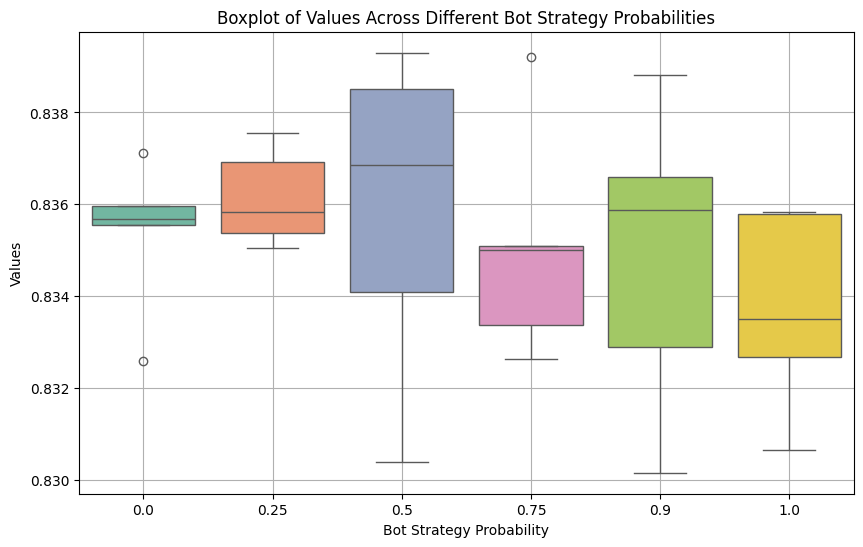

In [33]:
df_exploded = df_sweeps_results.explode('values')

# Convert the 'values' column to numeric
df_exploded['values'] = pd.to_numeric(df_exploded['values'].astype(str).str.strip('[]'))

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exploded, x='bot_strategy_prob', y='values', palette='Set2')

# Adding labels and title
plt.xlabel('Bot Strategy Probability')
plt.ylabel('Values')
plt.title('Boxplot of Values Across Different Bot Strategy Probabilities')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

### Part B - The bot plays with some probability as en expert & the DM has strategies that mimic the bot's behavior

In [34]:
sweep_ids = ["y66gmehh", "qiqr3r2d"]

directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)

df_sweeps_results = result_metric(sweep_ids, "bot_strategy_prob", drop_HPT=False, epoch="best")
df_sweeps_results

Total number of sweeps: 2
Download sweep_id='y66gmehh' data...
Download sweep_id='qiqr3r2d' data...
['config_seed', 'config_bot_strategy_prob']


<ipython-input-27-73f0339e8a9c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
<ipython-input-27-73f0339e8a9c>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
<ipython-input-27-73f0339e8a9c>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This

,mean,std,values,epoch,CI,CI_length,Min_Max
bot_strategy_prob,,,,,,,
0.00,0.834115,0.005702,"[0.8381466200805215, 0.8300827743507017]",17,"(0.8300827743507017, 0.8381466200805215)",0.008064,"(0.8300827743507017, 0.8381466200805215)"
0.25,0.834664,0.003524,"[0.8371562619973869, 0.8321727232631164]",13,"(0.8321727232631164, 0.8371562619973869)",0.004984,"(0.8321727232631164, 0.8371562619973869)"
0.50,0.835765,0.000171,"[0.8356439385087957, 0.835885353059037]",10,"(0.8356439385087957, 0.835885353059037)",0.000241,"(0.8356439385087957, 0.835885353059037)"
0.75,0.836350,0.001885,"[0.8376827927870907, 0.835016455959934]",last,"(0.835016455959934, 0.8376827927870907)",0.002666,"(0.835016455959934, 0.8376827927870907)"
0.90,0.837369,0.000757,"[0.8379044857068499, 0.8368342976166578]",18,"(0.8368342976166578, 0.8379044857068499)",0.001070,"(0.8368342976166578, 0.8379044857068499)"
1.00,0.835203,0.001370,"[0.8361718173384746, 0.8342348981848022]",17,"(0.8342348981848022, 0.8361718173384746)",0.001937,"(0.8342348981848022, 0.8361718173384746)"


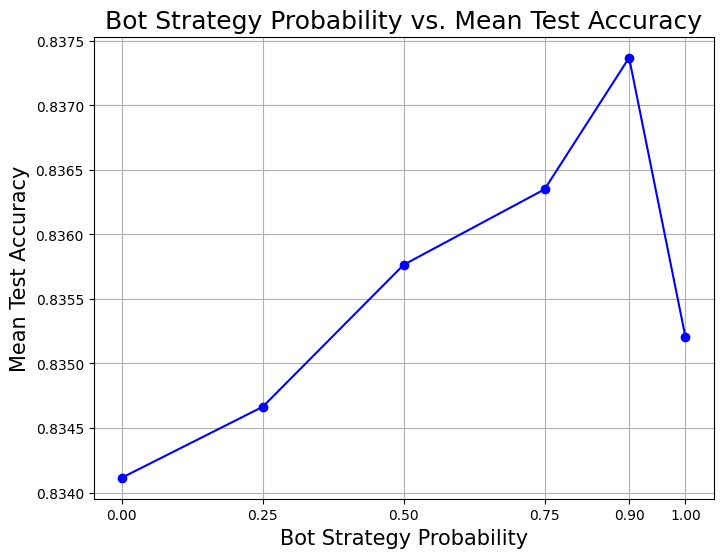

In [35]:
df_reset_index = df_sweeps_results.reset_index()
df = df_reset_index[['bot_strategy_prob', 'mean']]

plt.figure(figsize=(8, 6))
plt.plot(df['bot_strategy_prob'], df['mean'], marker='o', linestyle='-', color='b')

plt.xlabel('Bot Strategy Probability',fontsize=15)
plt.xticks([0, 0.25, 0.5, 0.75, 0.9, 1])
plt.ylabel('Mean Test Accuracy',fontsize=15)
plt.title('Bot Strategy Probability vs. Mean Test Accuracy',fontsize=18)


plt.grid(True)
plt.show()


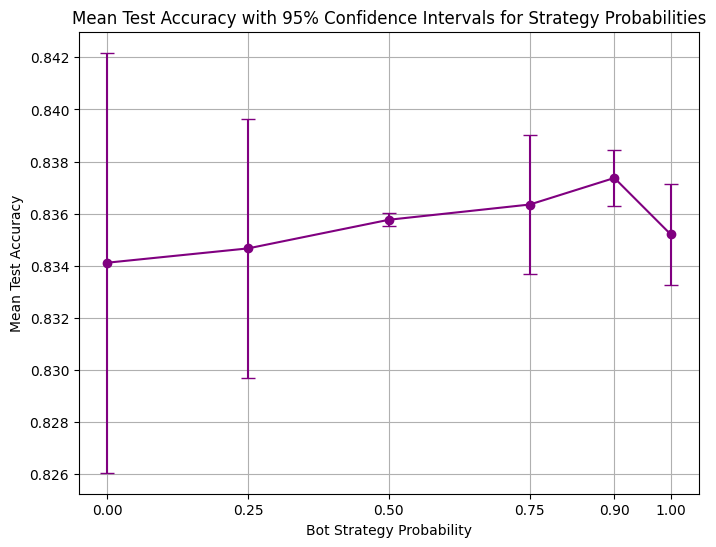

In [36]:
plt.figure(figsize=(8, 6))
plt.errorbar(df_sweeps_results.index, df_sweeps_results['mean'],
             yerr=df_sweeps_results['CI_length'], fmt='o', linestyle='-', capsize=5, color='purple')

plt.xlabel('Bot Strategy Probability')
plt.xticks([0, 0.25, 0.5, 0.75, 0.9, 1])
plt.ylabel('Mean Test Accuracy')
plt.title('Mean Test Accuracy with 95% Confidence Intervals for Strategy Probabilities')
plt.grid(True)
plt.show()


Total number of sweeps: 2
Download sweep_id='y66gmehh' data...
Download sweep_id='qiqr3r2d' data...


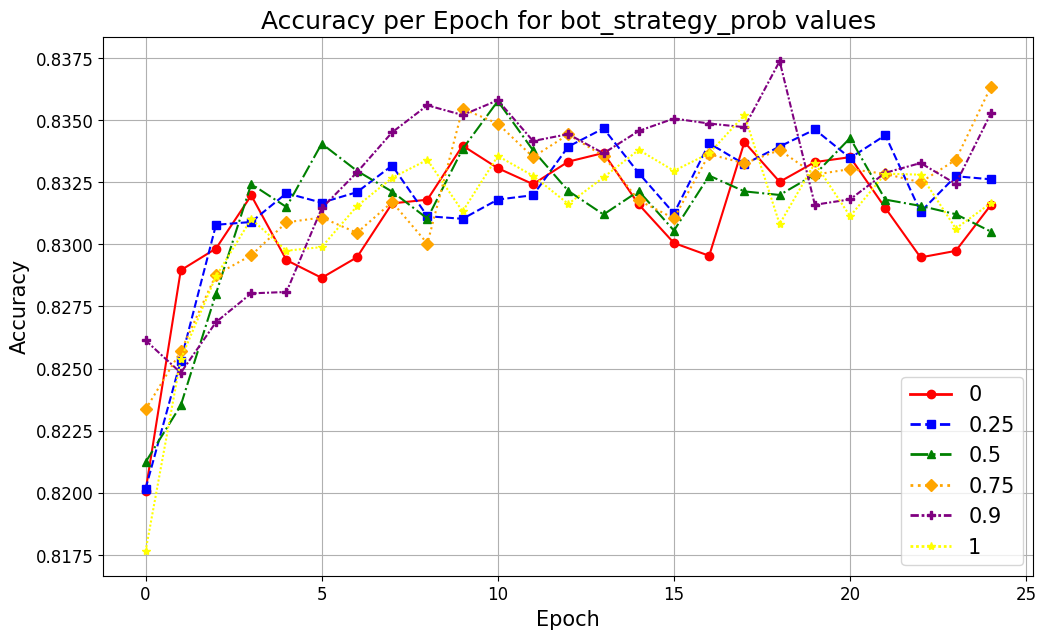

In [37]:
# Let us explore the accuracy per prob. along the epochs

df = api.get_sweeps_results(sweep_ids, metric=BASE_METRIC)

df = df[df['config_features'] == 'EFs']
df = df[df['config_online_simulation_factor'] == 4]

config_cols = [c for c in df.columns if "config_" in c and c != "config_wandb_run_id" and c != "config_online_simulation_size"]
param_cols = [col for col in config_cols if df[col].nunique() > 1 and col != "config_expert_reliability_path" and col != "config_seed"]
epoch_columns = [col for col in df.columns if "ENV_Test_accuracy_per_mean_user_and_bot_epoch" in col]

melted_df = df.melt(id_vars=param_cols + ["config_seed"], value_vars=epoch_columns, var_name='epoch', value_name='accuracy')
melted_df['epoch'] = melted_df['epoch'].str.extract('(\d+)').astype(int)
df_agg = melted_df.groupby(param_cols + ['epoch']).accuracy.agg(['mean', 'std']).reset_index()
df_agg = df_agg[df_agg['config_bot_strategy_prob'].isin([0, 0.25, 0.5 ,0.75, 0.9, 1])]

colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 1))]
markers = ['o', 's', '^', 'D', 'P', '*']
labels = [0, 0.25, 0.5 ,0.75, 0.9, 1]

# Plot each hyperparameter combination
unique_combinations = df_agg[param_cols].drop_duplicates()
plt.figure(figsize=(12, 7))

color_map = {idx: colors[i % len(colors)] for i, idx in enumerate(unique_combinations.index)}
linestyle_map = {idx: linestyles[i % len(linestyles)] for i, idx in enumerate(unique_combinations.index)}
marker_map = {idx: markers[i % len(markers)] for i, idx in enumerate(unique_combinations.index)}

for idx, combination in unique_combinations.iterrows():
    combination_mask = np.all([df_agg[col] == combination[col] for col in param_cols], axis=0)
    group = df_agg[combination_mask]
    plt.plot(group['epoch'], group['mean'], color=color_map[idx], linestyle=linestyle_map[idx], marker=marker_map[idx], label=f"Combination {idx}")

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy per Epoch for bot_strategy_prob values',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Create legend handles
handles = [Line2D([0], [0], color=color_map[idx], linestyle=linestyle_map[idx], marker=marker_map[idx], lw=2) for idx in unique_combinations.index]
plt.legend(handles=handles, labels=labels, loc='lower right', fontsize=15)

plt.grid(True)
plt.show()


<ipython-input-38-11968af85dbd>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_exploded, x='bot_strategy_prob', y='values', palette='Set2')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple t

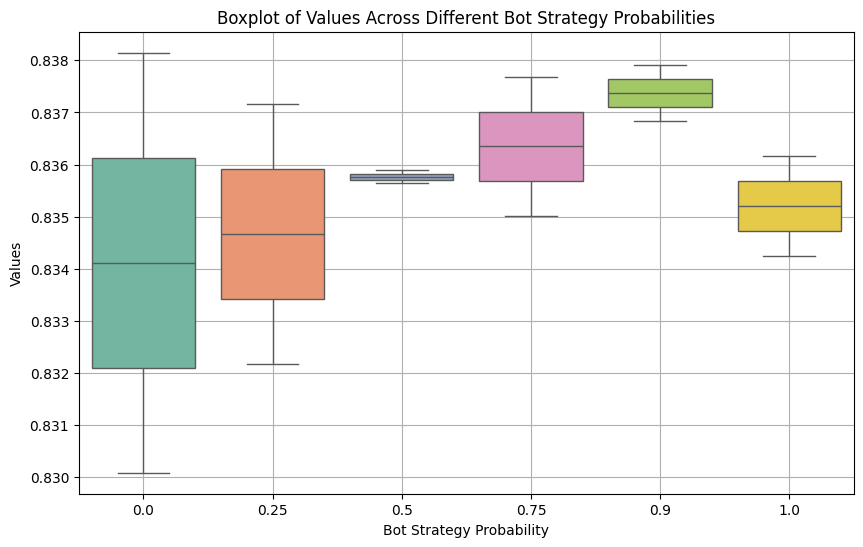

In [38]:
df_exploded = df_sweeps_results.explode('values')

# Convert the 'values' column to numeric
df_exploded['values'] = pd.to_numeric(df_exploded['values'].astype(str).str.strip('[]'))

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exploded, x='bot_strategy_prob', y='values', palette='Set2')

# Adding labels and title
plt.xlabel('Bot Strategy Probability')
plt.ylabel('Values')
plt.title('Boxplot of Values Across Different Bot Strategy Probabilities')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

### Part C - The bot plays with probability = 1 as en expert & the DM plays with pure and mixed strategies that mimic the bot's behavior

In [39]:
sweep_ids = ["27kkdjzy"]

directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)

df_api_results = api.get_sweeps_results(sweep_ids, metric=BASE_METRIC)
df_api_results = df_api_results[df_api_results['config_features'] == 'EFs']
df_api_results = df_api_results[df_api_results['config_online_simulation_factor'] == 4]
df_sweeps_results = result_metric(sweep_ids, "basic_nature", drop_HPT=False, epoch="best")
df_sweeps_results

Total number of sweeps: 1
Download sweep_id='27kkdjzy' data...
Total number of sweeps: 1
Download sweep_id='27kkdjzy' data...
['config_basic_nature']


<ipython-input-27-73f0339e8a9c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
<ipython-input-27-73f0339e8a9c>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
<ipython-input-27-73f0339e8a9c>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This

,mean,std,values,epoch,CI,CI_length,Min_Max
basic_nature,,,,,,,
18,0.828346,NaN,[0.8283458927379183],23,"(0.8283458927379183, 0.8283458927379183)",0.0,"(0.8283458927379183, 0.8283458927379183)"
19,0.831905,NaN,[0.8319046918091099],13,"(0.8319046918091099, 0.8319046918091099)",0.0,"(0.8319046918091099, 0.8319046918091099)"
20,0.830353,NaN,[0.8303527177417928],14,"(0.8303527177417928, 0.8303527177417928)",0.0,"(0.8303527177417928, 0.8303527177417928)"
21,0.831927,NaN,[0.8319266071515053],20,"(0.8319266071515053, 0.8319266071515053)",0.0,"(0.8319266071515053, 0.8319266071515053)"
22,0.829893,NaN,[0.8298930513497815],4,"(0.8298930513497815, 0.8298930513497815)",0.0,"(0.8298930513497815, 0.8298930513497815)"
23,0.833151,NaN,[0.8331506830176992],23,"(0.8331506830176992, 0.8331506830176992)",0.0,"(0.8331506830176992, 0.8331506830176992)"
26,0.832844,NaN,[0.8328442345747741],5,"(0.8328442345747741, 0.8328442345747741)",0.0,"(0.8328442345747741, 0.8328442345747741)"


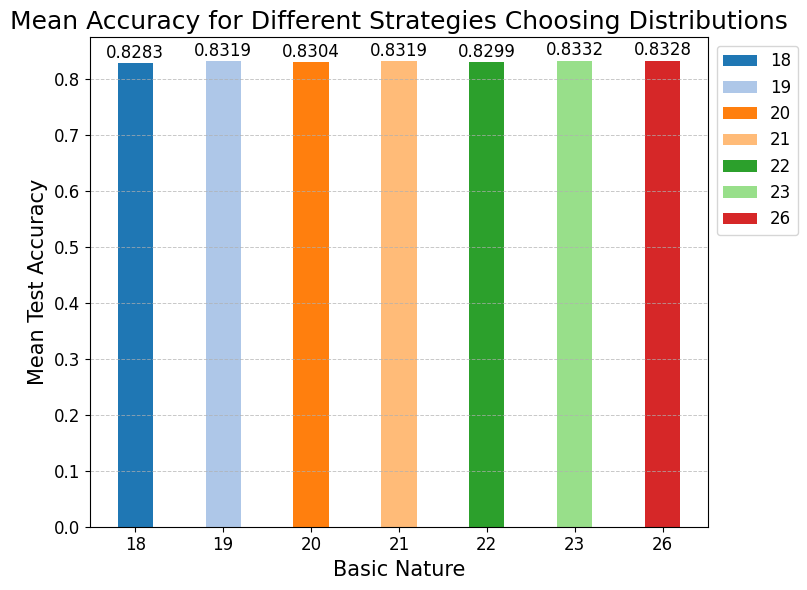

In [40]:

df_reset_index = df_sweeps_results.reset_index()
df = df_reset_index[['basic_nature', 'mean']]

plt.figure(figsize=(8, 6))
bar_width = 0.4
colors = plt.get_cmap('tab20').colors
labels = df['basic_nature'].unique()

x_positions = np.arange(len(df['basic_nature']))
bars = plt.bar(x_positions, df['mean'], bar_width, color=colors[:len(labels)])


plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.xlabel('Basic Nature', fontsize=15)
plt.ylabel('Mean Test Accuracy', fontsize=15)
plt.title('Mean Accuracy for Different Strategies Choosing Distributions', fontsize=18)
plt.xticks(x_positions, labels, fontsize=12, rotation=0, ha='center')
plt.yticks(fontsize=12)
plt.legend(bars, labels, fontsize=12, bbox_to_anchor=(1.00, 1), loc='upper left')

# mean value on top of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{bar.get_height():.4f}', ha='center', fontsize=12)



plt.tight_layout()
plt.show()
